# Практическое задание 2. Диффузионные модели


## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи).

Сдавать задание после указанного жёсткого срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи !!ВАЖНО!!!
Задания сдаются через систему google classroom. Посылка должна содержать:
* Ноутбук ddpm_hw_bmmo-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## В этом задании необходимо будет дореализовать ключевые формулы для обучения дискретной [ddpm](https://arxiv.org/pdf/2006.11239.pdf).  


---
Для выполнения домашнего задания достаточно использовать Google Colab.


In [4]:
# !pip3 install numpy torch torchvision

In [3]:
!python3 -V
import torch

print(f"torch.__version__: {torch.__version__}")

Python 3.10.12
torch.__version__: 2.0.1+cu118


In [7]:
%pip install wandb torch_ema denoising_diffusion_pytorch

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 35.7 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import random

import numpy as np
import torch


def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_global_seed(42)

## Dataset

In [5]:
from typing import Dict, Generator, Optional, Tuple, Union

import numpy as np
from cv2 import resize
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST


def preprocess_image(image: "PIL.Image") -> np.ndarray:
    image = np.array(image, dtype=np.uint8)
    image = resize(image, (32, 32))
    return np.array(image, dtype=np.float32) / 127.5 - 1


def postprocess_image(image: torch.Tensor) -> torch.Tensor:
    # convert values to [0; 255]
    image = image.cpu().detach()
    image = (image + 1) * 127.5
    image = torch.clip(image, 0, 255)
    return image


class MnistDataset(Dataset):
    def __init__(self, train: bool = True):
        super().__init__()
        self.mnist = MNIST("data", train=train, download=True)

    def __len__(self) -> int:
        return len(self.mnist)

    def __getitem__(self, index: int) -> Dict[str, Tensor]:
        image, target = self.mnist[index]
        image = preprocess_image(image)
        target = int(target)
        return {"images": Tensor(image)[None], "targets": target}

In [6]:
def dict_to_device(dct: Dict[str, Tensor], device: torch.device) -> Dict[str, Tensor]:
    return {k: v.to(device) for k, v in dct.items()}


def get_train_images_generator(
    batch_size: int = 128,
    num_workers: int = 0,
    shuffle: bool = True,
    drop_last: bool = True,
) -> Generator[Dict[str, Tensor], None, None]:
    dataset = MnistDataset(train=True)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        drop_last=drop_last,
    )
    while True:
        yield from loader

In [7]:
# для загрузки МНИСТа на локалку

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [8]:
def check_generator(batch_size: int = 128):
    generator = get_train_images_generator(batch_size)
    batch_dict = next(generator)
    assert (
        batch_dict["images"].shape == (batch_size, 1, 32, 32),
        batch_dict["images"].shape,
    )
    assert (batch_dict["targets"].shape == (batch_size,), batch_dict["targets"].shape)


check_generator(131)

<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:8: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:8: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_3273/203863153.py:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
/tmp/ipykernel_3273/203863153.py:8: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (batch_dict["targets"].shape == (batch_size,), batch_dict["targets"].shape)


In [9]:
GPU_name = "cuda:0" # 'mps:0' 'cuda:0'

## DDPM's dynamic, 5 pts



В `get_coeffs_primities` (2 pts) необходимо в возвращаеый словарь добавить рассчет коэффицентов, при помощи которых вы сможете реализовать семплирование из распределений $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$.

Например:
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha_t} = \prod_{t=1}^{T} \alpha_t$
- $\sqrt{\bar{\alpha_t}}$
- ...
- любые коэффиценты, которые помогут вам рассчитать коэффиценты в $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$

`extract_values_from_times` - по батчу с целочислненными временами выдает батч коэфиицентов в нужном шейпе для перемножения с батчом картинок


нам понадобятся здесь коэффициенты прежде всего для апостериорного q:

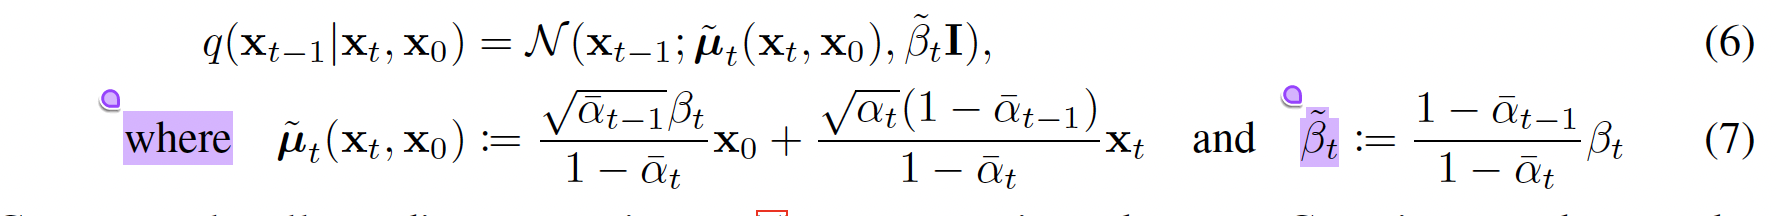

In [61]:
from typing import Dict

from torch import nn


def get_coeffs_primitives(
    T: int = 1000,
    beta_min: float = 1e-4,
    beta_max: float = 2e-2,
) -> Dict[str, Tensor]:
    """
    output: Dict[str, Tensor]
      {
        "a": b
      }
    ---
    b.shape == (T,)
    """
    betas = torch.linspace(beta_min, beta_max, T).float()
    alphas = 1 - betas

    sqrt_alphas = torch.sqrt(alphas)
    alphas_hat = torch.cumprod(alphas, dim=0)

    alphas_hat_prev = torch.cat([torch.FloatTensor([1.0]), alphas_hat[:-1]])

    # YOUR CODE GOES HERE
    sqrt_alphas_hat = torch.sqrt(alphas_hat)
    sqrt_1m_alphas_hat = torch.sqrt(1 - alphas_hat)
    posterior_mu_x0_coef = torch.sqrt(alphas_hat_prev) * betas / (1 - alphas_hat)
    posterior_mu_xt_coef = sqrt_alphas * (1 - alphas_hat_prev) / (1 - alphas_hat)
    posterior_std = torch.sqrt((1 - alphas_hat_prev) / (1 - alphas_hat) * betas)

    return {
        "betas": betas,
        "alphas": alphas,
        "alphas_hat": alphas_hat,
        "sqrt_alphas_hat": sqrt_alphas_hat,
        "sqrt_1m_alphas_hat": sqrt_1m_alphas_hat,
        "posterior_mu_x0_coef": posterior_mu_x0_coef,
        "posterior_mu_xt_coef": posterior_mu_xt_coef,
        "posterior_std": posterior_std,
    }


def extract_values_from_times(values: Tensor, times: torch.LongTensor) -> Tensor:
    values = values[times]
    return values[:, None, None, None]

`DDPMDynamic`: (3 pts)
- `__init__` - получаем коэффиценты, добавляем их в класс, как атрибуты, чтобы доставать их по имени без использования словаря
- `sample_from_posterior_q(x_t: FloatTensor, x_0: FloatTensor, t: LongTensor)` - $ x_{t-1} \sim q(x_{t-1} | x_{t}, x_0) $
- `forward` - $ x_{t} \sim q(x_t | x_0) $

`forward` - $ x_{t} \sim q(x_t | x_0) $

![image.png](attachment:0ac3bcba-90c4-4915-9f1a-ddaebbf5108a.png)

sample_from_posterior_q $x_{t-1} \sim q(x_{t-1} | x_{t}, x_0)$

![image.png](attachment:3f065365-39c8-490d-8679-04496cbc6566.png)

In [26]:
class DDPMDynamic(nn.Module):
    def __init__(
        self,
        T: int = 1000,
        beta_min: float = 1e-4,
        beta_max: float = 2e-2,
    ):
        super().__init__()
        self.T = T

        coeffs_primitives = get_coeffs_primitives(T, beta_min, beta_max)

        for name, tensor in coeffs_primitives.items():
            self.register_buffer(name, tensor)

    def sample_time_on_device(
        self, batch_size: int = 1, device: torch.device = torch.device("cpu")
    ):
        return torch.randint(0, self.T, (batch_size,), device=device)

    def sample_from_posterior_q(
        self, x_t: Tensor, x_0: Tensor, t: torch.LongTensor
    ) -> Tensor:
        # YOUR CODE GOES HERE
        posterior_mu_x0_coef = extract_values_from_times(self.posterior_mu_x0_coef, t)
        posterior_mu_xt_coef = extract_values_from_times(self.posterior_mu_xt_coef, t)
        posterior_std = extract_values_from_times(self.posterior_std, t)
        
        mu = posterior_mu_x0_coef * x_0 + posterior_mu_xt_coef * x_t
        eps = torch.randn_like(x_0)
        
        return mu + posterior_std * eps

    def get_x_zero(self, x_t: Tensor, eps: Tensor, t: torch.LongTensor) -> Tensor:
        # YOUR CODE GOES HERE
        sqrt_alphas_hat = extract_values_from_times(self.sqrt_alphas_hat, t)
        sqrt_1m_alphas_hat = extract_values_from_times(self.sqrt_1m_alphas_hat, t)
        
        x_0 = (x_t - sqrt_1m_alphas_hat * eps) / sqrt_alphas_hat
        return x_0

    def forward(self, batch: Dict[str, Tensor]) -> Dict[str, Tensor]:
        """
            Dict:
                x_0 - clean_image
                t - time (int \in [0; T - 1])
                eps - Optional[corresponding noise]
        Returns:
            Dict:
                x_t - noised_sample
                eps - corresponding noise
        """
        x_0 = batch["x_0"]
        t = batch["time"]

        # YOUR CODE GOES HERE
        eps = batch.get("eps", torch.randn_like(x_0))

        sqrt_alphas_hat = extract_values_from_times(self.sqrt_alphas_hat, t)
        std = extract_values_from_times(self.sqrt_1m_alphas_hat, t)
        x_t = sqrt_alphas_hat * x_0 + std * eps

        return {"x_t": x_t, "eps": eps}

In [27]:
def check_ddpm_dynamic():
    dynamic = DDPMDynamic()
    device = torch.device(GPU_name)
    # device = torch.device('cpu')
    dynamic.to(device)
    times = dynamic.sample_time_on_device(10, device)
    assert times.device == device, f"{times.device}, {device}"
    assert times.shape == (10,)


check_ddpm_dynamic()

### `Sampler`/DDPM's cycle: (1.5 pts)
- `single_step` - необходимо просемплировать $x_{t-1} \sim p(x_{t-1}|x_t)$
- `sample` - весь процесс обхода по марковской цепочки семплирования

![image.png](attachment:c1b83a1a-a4e9-486e-b491-337fa7d5527a.png)

In [28]:
from tqdm.auto import trange


class Sampler(nn.Module):
    def __init__(self, ddpm: nn.Module, dynamic: DDPMDynamic):
        super().__init__()
        ddpm.eval()
        self.ddpm = ddpm
        self.dynamic = dynamic

    @torch.no_grad()
    def single_step(self, x_t, t):
        # YOUR CODE GOES HERE
        eps_pred = self.ddpm(x_t, t)
        x0_pred = self.dynamic.get_x_zero(x_t, eps_pred, t)
        return self.dynamic.sample_from_posterior_q(x_t, x0_pred, t)

    @torch.no_grad()
    def sample(
        self,
        shape: Tuple[int, int, int, int],
        device: torch.device = torch.device("cpu"),
        verbose: bool = False,
    ) -> Tensor:
        self.ddpm.eval()
        x_t = torch.randn(shape, device=device)
        batch_size = shape[0]

        bar = trange if verbose else range
        for t in bar(self.dynamic.T - 1, -1, -1):
            t_tensor = torch.ones(batch_size, dtype=torch.int64, device=device) * t
            x_t = self.single_step(x_t, t_tensor)
        return x_t

### При помощи примитивов сверху реализовать обучение ddpm.


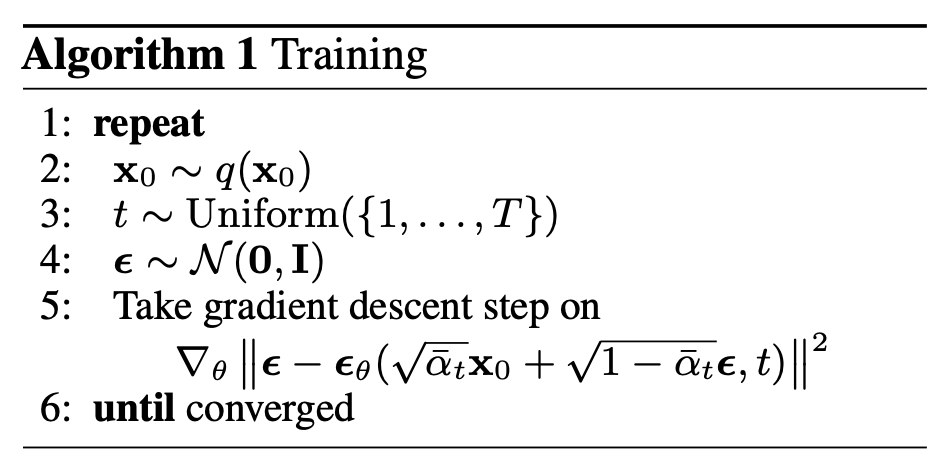

#### Diffusion Trainer


`DiffusionTrainer`: (1.5 pts)
- `calc_loss(clean_images: FloatTensor)` - необходимо внутри метода просемплировать время, далее просемплировать $x_t$, обработать батч, рассчитать лосс для обучения

In [29]:
import math

import torchvision
import wandb
from torch_ema import ExponentialMovingAverage
from torch.nn.functional import mse_loss 

class DiffusionTrainer:
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic,
        device: torch.device = torch.device("cpu"),
    ):
        self.ddpm = ddpm
        self.dynamic = dynamic
        self.dynamic.to(device)
        self.ddpm.to(device)
        self.sampler = Sampler(ddpm, dynamic)
        self.sampler.to(device)
        self.ema = ExponentialMovingAverage(ddpm.parameters(), decay=0.999)
        self.device = device
        self.optimizer = torch.optim.AdamW(
            self.ddpm.parameters(), lr=2e-4, weight_decay=1e-2
        )

        self.step = 0

    def switch_to_ema(self) -> None:
        self.ema.store(self.ddpm.parameters())
        self.ema.copy_to(self.ddpm.parameters())

    def switch_back_from_ema(self) -> None:
        self.ema.restore(self.ddpm.parameters())

    def calc_loss(self, x_0: torch.Tensor) -> torch.Tensor:
        
        # YOUR CODE GOES HERE
        ts = self.dynamic.sample_time_on_device(x_0.shape[0], self.device)
        batch = {"x_0": x_0, "time": ts}
        fwd_process_result = self.dynamic(batch)
        x_t, eps = fwd_process_result["x_t"], fwd_process_result["eps"]
        eps_pred = self.ddpm(x_t, ts)
        
        return mse_loss(eps, eps_pred)

    def log_metric(
        self,
        metric_name: str,
        loader_name: str,
        value: Union[float, torch.Tensor, wandb.Image],
    ):
        wandb.log({f"{metric_name}/{loader_name}": value}, step=self.step)

    def optimizer_logic(self, loss: torch.Tensor) -> None:
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.ema.update(self.ddpm.parameters())

    def train(
        self,
        train_generator: Generator[Dict[str, Tensor], None, None],
        total_iters: int = 1000,
        project_name: str = "discrete_time_ddpm",
        experiment_name: str = "mnist_baseline",
    ) -> None:
        session = wandb.init(project=project_name, name=experiment_name)

        self.ddpm.train()

        for iter_idx in trange(1, 1 + total_iters):
            self.step = iter_idx

            batch = next(train_generator)
            batch = dict_to_device(batch, device=self.device)

            loss = self.calc_loss(x_0=batch["images"])
            self.log_metric("mse", "train", loss)

            self.optimizer_logic(loss)

            if iter_idx % 1000 == 0:
                self.snapshot()

        self.ddpm.eval()
        self.switch_to_ema()

        session.finish()

    @torch.no_grad()
    def sample_images(self, batch_size: int, verbose: bool = False) -> torch.Tensor:
        x_pred = self.sampler.sample((batch_size, 1, 32, 32), self.device, verbose)
        x_pred = postprocess_image(x_pred)
        return x_pred

    @torch.no_grad()
    def snapshot(self) -> None:
        prev_mode = self.ddpm.training

        self.ddpm.eval()
        self.switch_to_ema()

        images = self.sample_images(100).cpu()
        nrow = 10
        grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
        grid = grid.data.numpy().astype(np.uint8)
        self.log_metric("images", "from_noise", wandb.Image(grid))

        self.switch_back_from_ema()
        self.ddpm.train(prev_mode)

#### Train

In [30]:
from denoising_diffusion_pytorch import Unet

set_global_seed(42)

ddpm = Unet(dim=64, dim_mults=(1, 2, 4, 4), channels=1, flash_attn=True)

In [31]:
device = torch.device(GPU_name)

In [32]:
trainer = DiffusionTrainer(ddpm, DDPMDynamic(), device)

In [33]:
generator = get_train_images_generator(128)

In [35]:
trainer.train(generator, total_iters=5000)

  0%|          | 14/5000 [00:02<17:00,  4.89it/s]wandb: WARNING Tried to log to step 1 that is less than the current step 23. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 23. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 23. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 23. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5 that is less than the current step 23. Steps must be monotonically increasing, so

Вы обучили большую модель, самое важное ее сохранить и не потерять!!!

In [40]:
trainer.switch_to_ema()
torch.save(ddpm.state_dict(), "./pretrained_ddpm_checkpoint.pth")

#### Безусловная генерация (неплохих картинок - 1 pts)

100%|██████████| 1000/1000 [00:42<00:00, 23.33it/s]


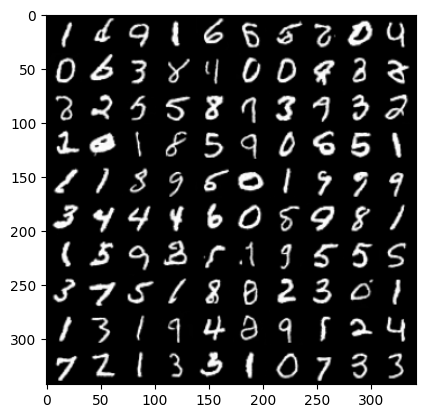

In [39]:
import math

from matplotlib import pyplot as plt


def sample_images(
    sampler: Sampler,
    batch_size: int == 100,
    device=torch.device("cpu"),
    verbose: bool = True,
):
    images = sampler.sample((batch_size, 1, 32, 32), device, True)
    images = postprocess_image(images)
    images = images.cpu()
    nrow = int(math.ceil(math.sqrt(batch_size)))
    grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)
    return grid


grid = sample_images(trainer.sampler, 100, trainer.device)

plt.imshow(grid)

### Опишите ваши выводы/результаты: (1 pts)

- Сначала про обучение: 

Как видно на скринах ниже, лосс нашей модели на последних 2к итерациях практически не меняется (а после 4к чуть ли не на плато выходит) 

Кажется, что можно сократить кол-во итераций на трейне без особой потери качества, но проверить эту гипотезу нет времени :) 

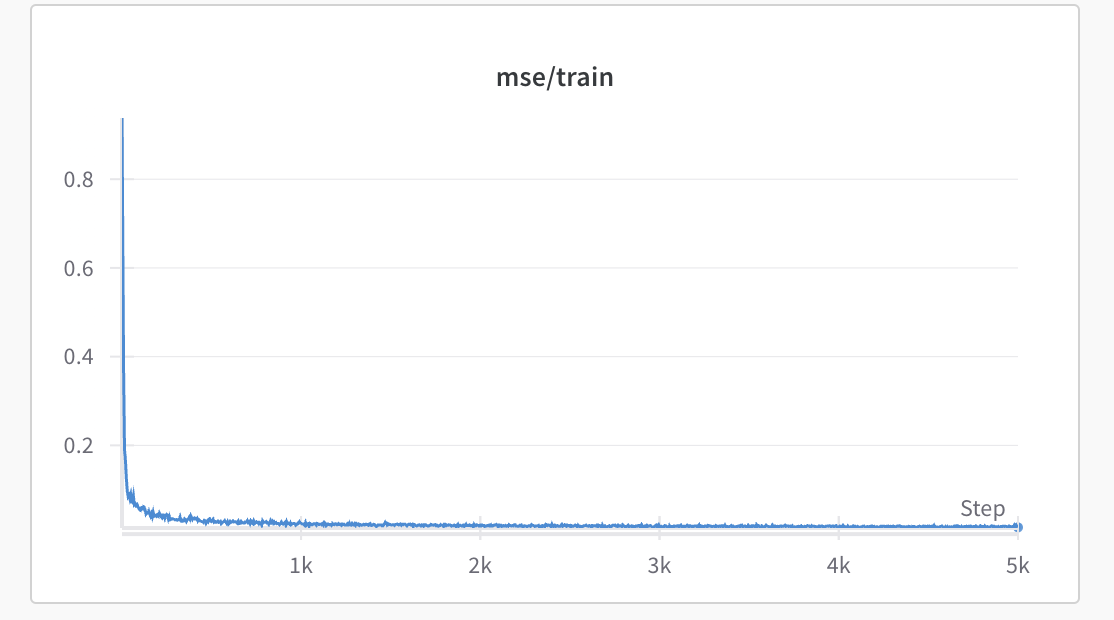

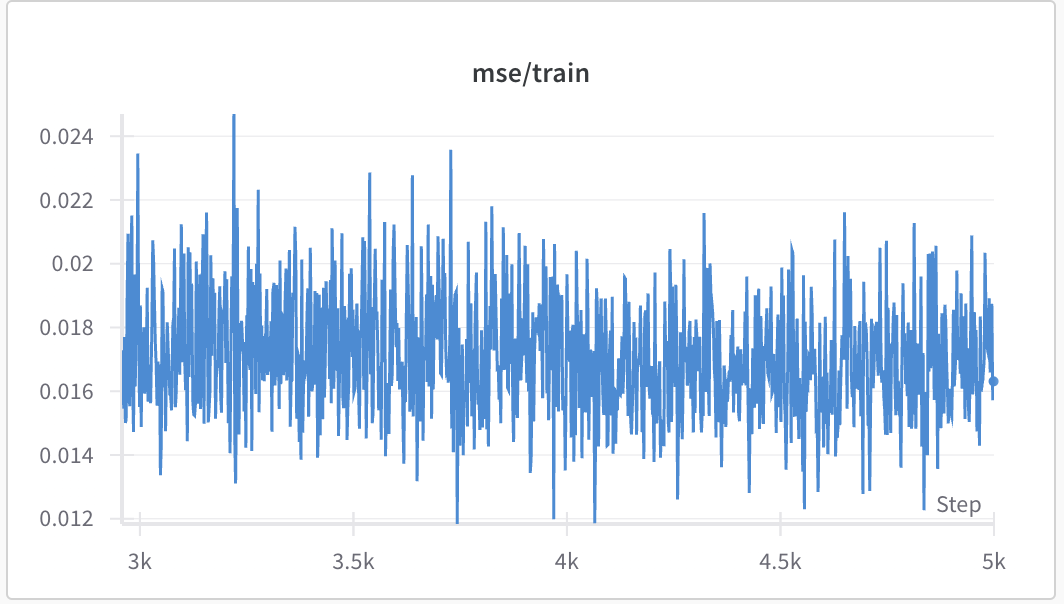

- Визуально результаты кажутся относительно неплохими: в большинстве картинок явно угадываются цифры, а загадочных иероглифов, клинописи и прочих артефактов не так много. (скрин на случай, если аутпуты почистятся)

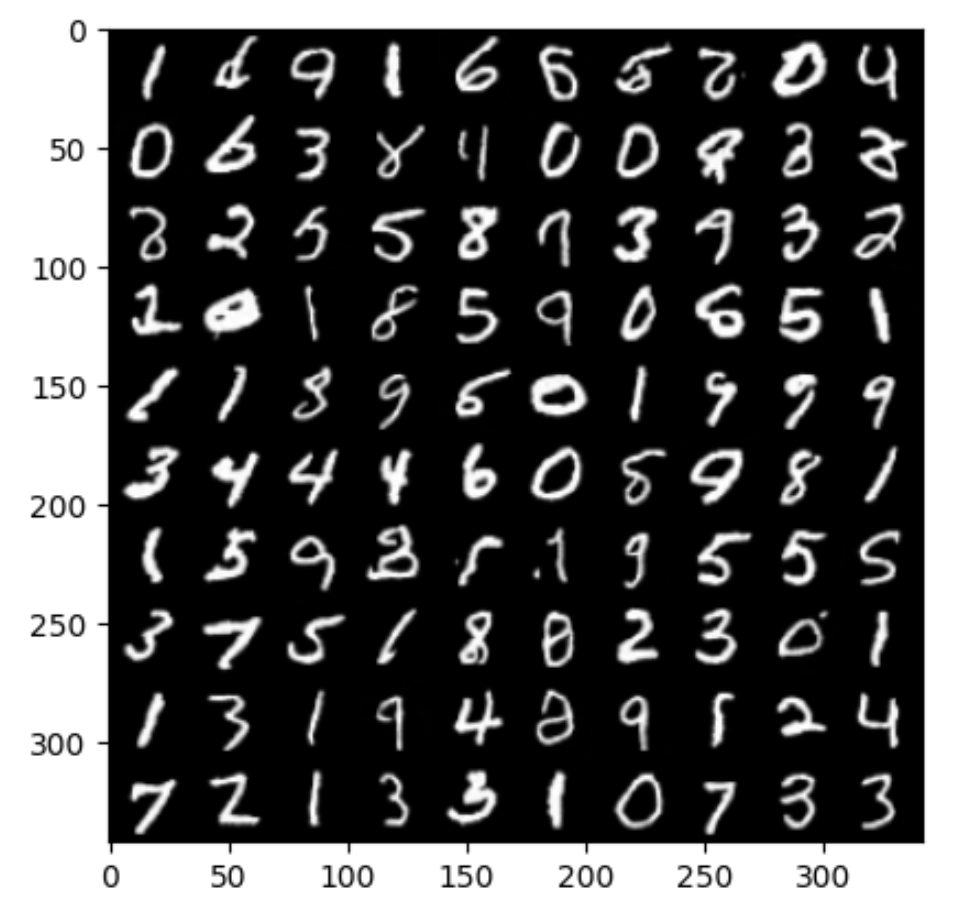

- При этом само наличие "артефактов" по построению почти неизбежно даже на таких простых примерах, тк мы пытаемся "выучить" распределение 

- Операция генерации при этом получается будто дорогостоящая (?) Пройти T шагов для каждой картинки... Теперь понятно, зачем в начале создаем словарик с предрассчитанными коэффициентами - надо экономить вычисления

- Было бы интересно поэксперементировать со количеством шагов T (и соответственно бетами), и попробовать упростить модель без серьезной потери в качестве

# Оценка качества (2 pts)

Для оценки качества часто используют метрику FID (Freche Inception Distance), чем ниже FID между двумя наборами изображений, тем более они похожи. На практике мерят FID между выборками одинакового размера, а в качестве эталонной выборки используют обучающую. Вам необходимо посчитать FID для 200, 1_000, 5_000, 8_000 и 10_000 изображений.

Эталоном считается FID посчитанный на выборках размера 50_000 изображений, но это слишком долго в рамках учебной задачи.

Идейно FID равен расстоянию Фреше (расстоянию между двумя нормальными распределениями) в латентном пространстве хорошего классификатора (Inception V3).

Для подсчета метрики, можно использовать [библиотечную реализацию](https://github.com/mseitzer/pytorch-fid)

**Подсказка**

Вы можете сразу сгенерировать 10_000 изображений, а потом аккуратно брать нужное количество для экономии времени.


In [42]:
%pip install pytorch-fid

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [43]:
import os

import PIL
from pytorch_fid.fid_score import calculate_fid_given_paths
from tqdm import tqdm

In [44]:
set_global_seed(42)

ddpm = Unet(dim=64, dim_mults=(1, 2, 4, 4), channels=1, flash_attn=True)

In [45]:
checkpoint = torch.load("./pretrained_ddpm_checkpoint.pth")

ddpm.load_state_dict(checkpoint)
ddpm.eval()

Unet(
  (init_conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=128, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): RMSNorm()
          (act): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (block2): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): RMSNorm()
          (act): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (res_conv): Identity()
      )
      (2): Line

In [46]:
device = torch.device(GPU_name)

In [47]:
trainer = DiffusionTrainer(ddpm, DDPMDynamic(), device)

In [58]:
@torch.no_grad()
def gen_imgs(
    sampler: Sampler, folder: str,
    device = torch.device(GPU_name),
    count: int = 10_000, batch_size: int = 100, seed: int = 42
):

    set_global_seed(seed)
    os.makedirs(folder, exist_ok=True)
    iter_num = count // batch_size + int(count % batch_size > 0)

    for _ in tqdm(range(iter_num)):

        already_sampled = len(os.listdir(folder))
        bs = min(batch_size, count - already_sampled)

        images = sampler.sample((bs, 1, 32, 32), device, True)
        images = postprocess_image(images)
        images = images.cpu().permute(0, 2, 3, 1).numpy().astype('uint8')

        for i in range(images.shape[0]):
            index = already_sampled + i

            file_name = os.path.join(folder, f'img_{index:05d}.png')
            PIL.Image.fromarray(images[i, :, :, 0], 'L').save(file_name)

In [59]:
def extract_dataset(folder: str, count: int = 10_000):

    os.makedirs(folder, exist_ok=True)
    data = MnistDataset()

    for i in tqdm(range(count)):
        img = data[i]['images']
        img = postprocess_image(img)
        img = img.cpu().permute(1, 2, 0).numpy().astype('uint8')

        file_name = os.path.join(folder, f'img_{i:05d}.png')
        PIL.Image.fromarray(img[:, :, 0], 'L').save(file_name)

In [54]:
extract_dataset("./mnist_data_img")

100%|██████████| 10000/10000 [00:23<00:00, 423.63it/s]


In [ ]:
# Долгая функция

gen_imgs(trainer.sampler, "./mnist_gen_img")

 52%|█████▎    | 525/1000 [00:22<00:20, 23.33it/s]

In [62]:
path_dataset = './mnist_data_img'
path_output  = "./mnist_gen_img"


fid = calculate_fid_given_paths(
        [path_dataset, path_output],
        batch_size=100,
        device=device,
        dims=2048,
        num_workers=12
    )

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /tmp/xdg_cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 58.9MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what 

Нарисуйте график значения FID в зависимости от размера выборок. Учтите, что для корректной работы выборки должны быть одинакового размера. Какие выводы вы можете сделать?

In [63]:
fid

3.5364170741071916

Пойдем по максимально ~~тупому~~ надежному пути, и напрямую разложим изображения по папкам с заданным количеством

In [80]:
import os
import shutil
from tqdm import tqdm_notebook

def create_duplicate_folders(source_folder, sizes):
    """расфасуем по папкам"""
    # Создаем новую папку с суффиксом _dupl
    dupl_folder = f"{source_folder}_dupl"
    os.makedirs(dupl_folder, exist_ok=True)

    # Получаем список всех изображений в исходной папке
    images = [img for img in os.listdir(source_folder) if img.endswith('.png')]

    # Сортируем имена изображений для правильного порядка
    images.sort()

    # Создаем подкаталоги и копируем изображения
    for size in tqdm_notebook(sizes):
        subfolder_name = f"first_{size}"
        subfolder_path = os.path.join(dupl_folder, subfolder_name)
        os.makedirs(subfolder_path, exist_ok=True)

        # Копируем первые size изображений
        for img in images[:size]:
            shutil.copy(os.path.join(source_folder, img), subfolder_path)

In [96]:
sizes = [100, 500, 1000, 3000, 5000, 9000]

In [78]:
# Пример использования
source_folder = './mnist_data_img' 
create_duplicate_folders(source_folder, sizes)


In [81]:
# Пример использования
source_folder = './mnist_gen_img' 
create_duplicate_folders(source_folder, sizes)


/tmp/ipykernel_3273/4056727509.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for size in tqdm_notebook(sizes):


  0%|          | 0/6 [00:00<?, ?it/s]

In [82]:
def calc_fid(path_dataset, path_output, size, device):
    
    path_dataset_final = os.path.join(path_dataset, f'first_{size}')
    path_output_final = os.path.join(path_output, f'first_{size}')
    
    fid_ = calculate_fid_given_paths(
            [path_dataset_final, path_output_final],
            batch_size=100,
            device=device,
            dims=2048,
            num_workers=12
    )
    
    return fid_                                 

In [89]:
fid_res = {}

for size in tqdm_notebook(sizes):
    
    fid_ = calc_fid('mnist_data_img_dupl', 'mnist_gen_img_dupl', size, device)
    
    fid_res[size] = fid_

/tmp/ipykernel_3273/2664744228.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for size in tqdm_notebook(sizes):


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

100%|████

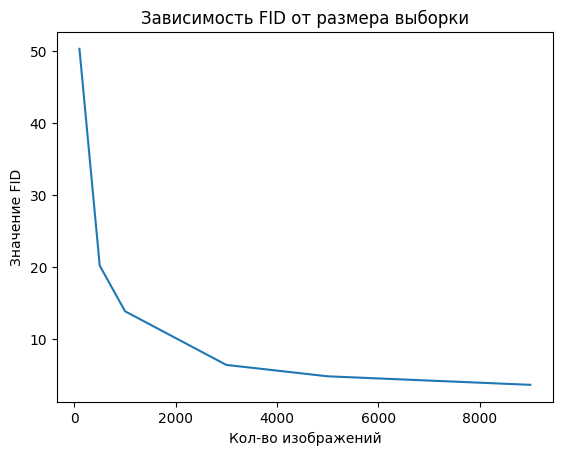

In [95]:
res = list(fid_res.items())
x = [i[0] for i in res]
y = [i[1] for i in res]

import matplotlib.pyplot as plt
plt.plot(x, y)
plt.title('Зависимость FID от размера выборки')
plt.xlabel('Кол-во изображений')
plt.ylabel('Значение FID');

In [69]:
# !du -h